Credit: This notebook is largely apated from Taron Zakaryan's Kaggle Notebook

## 1. Libraries and settings

In [1]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable


ModuleNotFoundError: No module named 'torch'

## 2. Load data

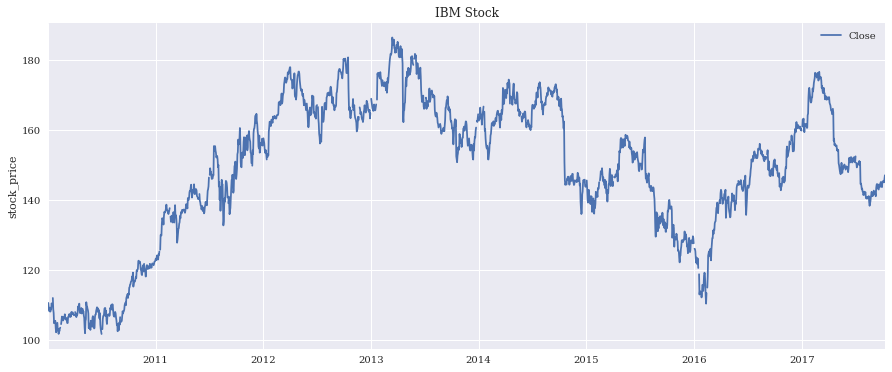

In [2]:
dates = pd.date_range('2010-01-02','2017-10-11',freq='B')
df1=pd.DataFrame(index=dates)
df_ibm=pd.read_csv("ibm.us.txt", parse_dates=True, index_col=0)
df_ibm=df1.join(df_ibm)
df_ibm[['Close']].plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("IBM Stock")
plt.show()

In [3]:
df_ibm=df_ibm[['Close']]
df_ibm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2028 entries, 2010-01-04 to 2017-10-11
Freq: B
Data columns (total 1 columns):
Close    1958 non-null float64
dtypes: float64(1)
memory usage: 111.7 KB


In [4]:
df_ibm=df_ibm.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df_ibm['Close'] = scaler.fit_transform(df_ibm['Close'].values.reshape(-1,1))
#df_ibm

In [5]:
print(scaler.min_)
print(scaler.data_max_)
print(scaler.scale_)
print(scaler.data_range_)

[-3.40463247]
[186.36]
[0.02363507]
[84.62]


In [6]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_ibm, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1574, 59, 1)
y_train.shape =  (1574, 1)
x_test.shape =  (394, 59, 1)
y_test.shape =  (394, 1)


In [7]:
# save testing data for C++
pd.DataFrame(x_test[:,:,0]).to_csv("x_test.csv",index=False)
pd.DataFrame(y_test).to_csv("y_test.csv",index=False)

In [8]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [9]:
y_train.size(),x_train.size()

(torch.Size([1574, 1]), torch.Size([1574, 59, 1]))

## 3. Build the structure of model

In [10]:
# Build model
#####################
input_dim = 1
hidden_dim = 5
num_layers = 1 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)
6
torch.Size([20, 1])
torch.Size([20, 5])
torch.Size([20])
torch.Size([20])
torch.Size([1, 5])
torch.Size([1])


In [11]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 9:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  9 MSE:  0.14484116435050964
Epoch  19 MSE:  0.034036919474601746
Epoch  29 MSE:  0.01995120756328106
Epoch  39 MSE:  0.0122525654733181
Epoch  49 MSE:  0.00670578284189105
Epoch  59 MSE:  0.004723239690065384
Epoch  69 MSE:  0.0038693808019161224
Epoch  79 MSE:  0.0035630431957542896
Epoch  89 MSE:  0.0034171449951827526
Epoch  99 MSE:  0.0032796990126371384


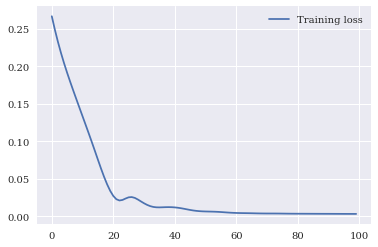

In [12]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [13]:
np.shape(y_train_pred)

torch.Size([1574, 1])

In [14]:
import time

In [15]:
torch.save(model.state_dict(), 'model_saved')

In [16]:
start_time = time.time()

y_test_pred_0 = model(x_test[0].reshape(1,59,1))
y_train_pred_0 = scaler.inverse_transform(y_test_pred_0.detach().numpy())

print("--- %s seconds ---" % (time.time() - start_time))

print(y_train_pred_0)

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

--- 0.0052089691162109375 seconds ---
[[141.41286]]
Train Score: 2.42 RMSE
Test Score: 1.84 RMSE


In [17]:
x_test.shape

torch.Size([394, 59, 1])

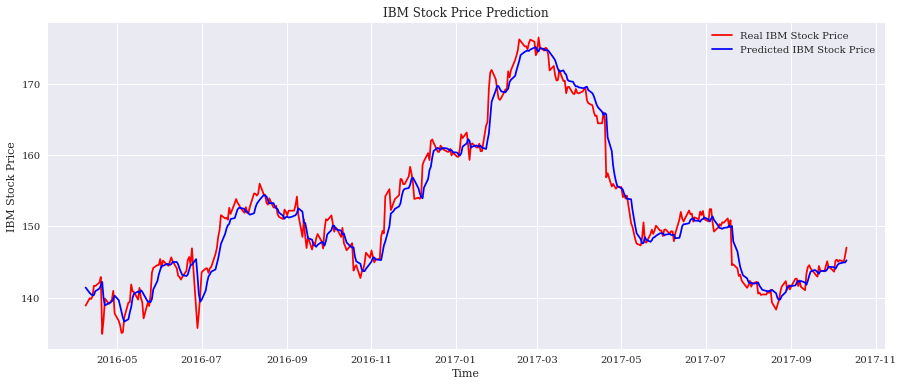

In [18]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, y_test, color = 'red', label = 'Real IBM Stock Price')
axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted IBM Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.savefig('ibm_pred.png')
plt.show()

In [19]:
state = model.state_dict()
print(state)
# print(np.transpose(state['lstm.weight_ih_l0']))
# print(np.transpose(state['lstm.bias_ih_l0']))
# print(np.transpose(state['lstm.weight_hh_l0']))
# print(np.transpose(state['lstm.bias_hh_l0']))
# print(state['fc.weight'])
# print(state['fc.bias'])

OrderedDict([('lstm.weight_ih_l0', tensor([[ 0.0836],
        [-0.0514],
        [-0.2549],
        [-0.1989],
        [ 0.4454],
        [ 0.4859],
        [-0.1078],
        [ 0.4766],
        [-0.2240],
        [ 0.3338],
        [ 0.1804],
        [ 0.4706],
        [-0.6070],
        [-0.6866],
        [ 0.1765],
        [ 0.6515],
        [-0.0215],
        [ 0.2806],
        [-0.3467],
        [-0.0565]])), ('lstm.weight_hh_l0', tensor([[-0.1701, -0.1283, -0.7262, -0.0963,  0.5072],
        [-0.4644, -0.4242, -0.1438, -0.0357, -0.0484],
        [-0.4107, -0.1465, -0.4118, -0.0019,  0.5440],
        [ 0.1130, -0.4685, -0.2745,  0.4419, -0.2476],
        [-0.2394,  0.3489, -0.4345, -0.4317,  0.2834],
        [-0.2045,  0.0377, -0.0026, -0.1690,  0.6018],
        [ 0.2871,  0.1028,  0.6552,  0.5539,  0.0526],
        [-0.3933, -0.0395, -0.0622,  0.5314,  0.1301],
        [-0.5946, -0.1316,  0.3952,  0.6251,  0.1453],
        [ 0.0012, -0.3365, -0.4961,  0.0550, -0.1045],
        [ 

In [20]:
pd.DataFrame(state['lstm.weight_ih_l0'].numpy()).to_csv("weight_ih_l0.csv",index=False)
pd.DataFrame(state['lstm.bias_ih_l0'].numpy()).to_csv("bias_ih_l0.csv",index=False)
pd.DataFrame(state['lstm.weight_hh_l0'].numpy()).to_csv("weight_hh_l0.csv",index=False)
pd.DataFrame(state['lstm.bias_hh_l0'].numpy()).to_csv("bias_hh_l0.csv",index=False)
pd.DataFrame(state['fc.weight'].numpy()).to_csv("fc.weight.csv",index=False)
pd.DataFrame(state['fc.bias'].numpy()).to_csv("fc.bias.csv",index=False)

In [21]:
pd.DataFrame(y_test_pred).to_csv("y_test_pred.csv",index=False)

In [22]:
np.transpose(x_test[0])

tensor([[-0.5547, -0.5547, -0.5970, -0.7339, -0.7107, -0.7199, -0.7289, -0.7178,
         -0.7535, -0.7261, -0.6693, -0.6686, -0.7100, -0.6710, -0.6067, -0.5866,
         -0.5932, -0.6578, -0.7436, -0.7953, -0.7247, -0.7247, -0.6871, -0.6126,
         -0.4720, -0.4580, -0.4427, -0.4732, -0.4642, -0.4268, -0.4814, -0.5034,
         -0.4297, -0.3867, -0.3538, -0.3538, -0.3016, -0.3255, -0.2954, -0.3006,
         -0.2527, -0.2432, -0.2394, -0.1990, -0.1491, -0.1480, -0.1137, -0.1257,
         -0.1851, -0.1288, -0.1288, -0.1189, -0.0983, -0.1186, -0.0513, -0.0274,
         -0.0373, -0.0832, -0.0827]])

In [23]:
y_test_pred

array([[141.41286],
       [140.64757],
       [140.45627],
       [140.31302],
       [140.35742],
       [140.8975 ],
       [141.27008],
       [141.686  ],
       [142.21342],
       [139.89345],
       [138.90863],
       [139.23413],
       [139.30309],
       [139.48564],
       [139.70547],
       [140.27922],
       [139.63882],
       [138.82166],
       [138.03642],
       [137.16374],
       [136.62747],
       [136.96568],
       [137.93057],
       [138.66498],
       [139.96649],
       [140.5439 ],
       [140.85979],
       [140.67603],
       [141.04523],
       [140.83015],
       [140.46056],
       [139.44252],
       [139.45853],
       [139.35583],
       [139.78937],
       [141.14903],
       [142.33757],
       [143.26373],
       [143.85048],
       [144.47961],
       [144.46661],
       [144.73416],
       [144.69276],
       [144.5948 ],
       [144.70631],
       [144.99762],
       [145.00815],
       [144.66846],
       [144.06773],
       [143.59761],


In [24]:
x_test[0].flatten()

tensor([-0.5547, -0.5547, -0.5970, -0.7339, -0.7107, -0.7199, -0.7289, -0.7178,
        -0.7535, -0.7261, -0.6693, -0.6686, -0.7100, -0.6710, -0.6067, -0.5866,
        -0.5932, -0.6578, -0.7436, -0.7953, -0.7247, -0.7247, -0.6871, -0.6126,
        -0.4720, -0.4580, -0.4427, -0.4732, -0.4642, -0.4268, -0.4814, -0.5034,
        -0.4297, -0.3867, -0.3538, -0.3538, -0.3016, -0.3255, -0.2954, -0.3006,
        -0.2527, -0.2432, -0.2394, -0.1990, -0.1491, -0.1480, -0.1137, -0.1257,
        -0.1851, -0.1288, -0.1288, -0.1189, -0.0983, -0.1186, -0.0513, -0.0274,
        -0.0373, -0.0832, -0.0827])